Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
0 0.695055 0.677288 0.680812 0.709298


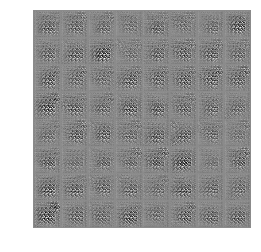

In [2]:
# import toolbox
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def montage(images):
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    m = np.ones((images.shape[1] * n_plots + n_plots + 1, images.shape[2] * n_plots + n_plots + 1)) * 0.5
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w] = this_img
    return m

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')
tf.reset_default_graph()
batch_size = 64
n_noise = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
noise = tf.placeholder(dtype=tf.float32, shape=[None, n_noise])

keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')
is_training = tf.placeholder(dtype=tf.bool, name='is_training')

def lrelu(x):
    return tf.maximum(x, tf.multiply(x, 0.2))

def binary_cross_entropy(x, z):
    eps = 1e-12
    return (-(x * tf.log(z + eps) + (1. - x) * tf.log(1. - z + eps)))

def discriminator(img_in, reuse=None, keep_prob=keep_prob):
    # try this CNN alone
    activation = lrelu
    with tf.variable_scope("discriminator", reuse=reuse):
        x = tf.reshape(img_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=128, activation=activation)
        x = tf.layers.dense(x, units=1, activation=tf.nn.sigmoid)
        return x
    
def generator(z, keep_prob=keep_prob, is_training=is_training):
    activation = lrelu
    momentum = 0.99
    with tf.variable_scope("generator", reuse=None):
        x = z
        d1 = 4
        d2 = 1
        x = tf.layers.dense(x, units=d1 * d1 * d2, activation=activation)
        x = tf.layers.dropout(x, keep_prob)      
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)  
        x = tf.reshape(x, shape=[-1, d1, d1, d2])
        x = tf.image.resize_images(x, size=[7, 7])
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=1, strides=1, padding='same', activation=tf.nn.sigmoid)
        return x
    
g = generator(noise, keep_prob, is_training)
d_real = discriminator(X_in)
d_fake = discriminator(g, reuse=True)

vars_g = [var for var in tf.trainable_variables() if var.name.startswith("generator")]
vars_d = [var for var in tf.trainable_variables() if var.name.startswith("discriminator")]


d_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_d)
g_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_g)

loss_d_real = binary_cross_entropy(tf.ones_like(d_real), d_real)
loss_d_fake = binary_cross_entropy(tf.zeros_like(d_fake), d_fake)
loss_g = tf.reduce_mean(binary_cross_entropy(tf.ones_like(d_fake), d_fake))
loss_d = tf.reduce_mean(0.5 * (loss_d_real + loss_d_fake))

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer_d = tf.train.RMSPropOptimizer(learning_rate=0.00015).minimize(loss_d + d_reg, var_list=vars_d)
    optimizer_g = tf.train.RMSPropOptimizer(learning_rate=0.00015).minimize(loss_g + g_reg, var_list=vars_g)
    
    
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(1000):
    train_d = True
    train_g = True
    keep_prob_train = 0.6 # 0.5
    
    n = np.random.uniform(0.0, 1.0, [batch_size, n_noise]).astype(np.float32)   
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]  
    
    d_real_ls, d_fake_ls, g_ls, d_ls = sess.run([loss_d_real, loss_d_fake, loss_g, loss_d], feed_dict={X_in: batch, noise: n, keep_prob: keep_prob_train, is_training:True})
    
    d_real_ls = np.mean(d_real_ls)
    d_fake_ls = np.mean(d_fake_ls)
    g_ls = g_ls
    d_ls = d_ls
    
    if g_ls * 1.5 < d_ls:
        train_g = False
        pass
    if d_ls * 2 < g_ls:
        train_d = False
        pass
    
    if train_d:
        sess.run(optimizer_d, feed_dict={noise: n, X_in: batch, keep_prob: keep_prob_train, is_training:True})
        
        
    if train_g:
        sess.run(optimizer_g, feed_dict={noise: n, keep_prob: keep_prob_train, is_training:True})
        
        
    if not i % 5000:
        print (i, d_ls, g_ls, d_real_ls, d_fake_ls)
        if not train_g:
            print("not training generator")
        if not train_d:
            print("not training discriminator")
        gen_img = sess.run(g, feed_dict = {noise: n, keep_prob: 1.0, is_training:False})
        imgs = [img[:,:,0] for img in gen_img]
        m = montage(imgs)
        gen_img = m
        plt.axis('off')
        plt.imshow(gen_img, cmap='gray')
        plt.show()

In [ ]:
z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])
z.shape

In [ ]:
from __future__ import division, print_function, absolute_import

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# Training Params
num_steps = 1000
batch_size = 128
learning_rate = 0.0002

# Network Params
image_dim = 784 # 28*28 pixels
gen_hidden_dim = 256
disc_hidden_dim = 256
noise_dim = 100 # Noise data points

# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

# Store layers weight & bias
weights = {
    'gen_hidden1': tf.Variable(glorot_init([noise_dim, gen_hidden_dim])),
    'gen_out': tf.Variable(glorot_init([gen_hidden_dim, image_dim])),
    'disc_hidden1': tf.Variable(glorot_init([image_dim, disc_hidden_dim])),
    'disc_out': tf.Variable(glorot_init([disc_hidden_dim, 1])),
}
biases = {
    'gen_hidden1': tf.Variable(tf.zeros([gen_hidden_dim])),
    'gen_out': tf.Variable(tf.zeros([image_dim])),
    'disc_hidden1': tf.Variable(tf.zeros([disc_hidden_dim])),
    'disc_out': tf.Variable(tf.zeros([1])),
}


# Generator
def generator(x):
    hidden_layer = tf.matmul(x, weights['gen_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases['gen_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights['gen_out'])
    out_layer = tf.add(out_layer, biases['gen_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer


# Discriminator
def discriminator(x):
    hidden_layer = tf.matmul(x, weights['disc_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases['disc_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights['disc_out'])
    out_layer = tf.add(out_layer, biases['disc_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer

# Build Networks
# Network Inputs
gen_input = tf.placeholder(tf.float32, shape=[None, noise_dim], name='input_noise')
disc_input = tf.placeholder(tf.float32, shape=[None, image_dim], name='disc_input')

# Build Generator Network
gen_sample = generator(gen_input)

# Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(disc_input)
disc_fake = discriminator(gen_sample)

# Build Loss
gen_loss = -tf.reduce_mean(tf.log(disc_fake))
disc_loss = -tf.reduce_mean(tf.log(disc_real) + tf.log(1. - disc_fake))

# Build Optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate)

# Training Variables for each optimizer
# By default in TensorFlow, all variables are updated by each optimizer, so we
# need to precise for each one of them the specific variables to update.
# Generator Network Variables
gen_vars = [weights['gen_hidden1'], weights['gen_out'],
            biases['gen_hidden1'], biases['gen_out']]
# Discriminator Network Variables
disc_vars = [weights['disc_hidden1'], weights['disc_out'],
            biases['disc_hidden1'], biases['disc_out']]

# Create training operations
train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for i in range(1, num_steps+1):
        # Prepare Data
        # Get the next batch of MNIST data (only images are needed, not labels)
        batch_x, _ = mnist.train.next_batch(batch_size)
        # Generate noise to feed to the generator
        z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])

        # Train
        feed_dict = {disc_input: batch_x, gen_input: z}
        _, _, gl, dl = sess.run([train_gen, train_disc, gen_loss, disc_loss],
                                feed_dict=feed_dict)
        if i % 1000 == 0 or i == 1:
            print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))

    # Generate images from noise, using the generator network.
    f, a = plt.subplots(4, 10, figsize=(10, 4))
    for i in range(10):
        # Noise input.
        z = np.random.uniform(-1., 1., size=[4, noise_dim])
        g = sess.run([gen_sample], feed_dict={gen_input: z})
        g = np.reshape(g, newshape=(4, 28, 28, 1))
        # Reverse colours for better display
        g = -1 * (g - 1)
        for j in range(4):
            # Generate image from noise. Extend to 3 channels for matplot figure.
            img = np.reshape(np.repeat(g[j][:, :, np.newaxis], 3, axis=2),
                             newshape=(28, 28, 3))
            a[j][i].imshow(img)

    f.show()
    plt.draw()